# Volume 2: The Discrete Fourier Transform

## Introduction

Digital audio processing relies on sampling continuous sound waves and analyzing their frequency content. The Discrete Fourier Transform (DFT) decomposes a sampled signal into its constituent frequencies, enabling applications from tone generation to chord recognition and filtering.

In this lab we are going to implement a Python class for handling WAV files, visualizing waveforms and their DFTs, constructing pure tones and chords, and using fourier transform to detect unknown chord tones.

## Method

First, the `SoundWave` class stores the sample rate and samples, and computes the time and frequency axes. It provides the following methods:

- `plot`: Visualizes the time‑domain waveform or, when requested, the magnitude spectrum of the first half of the frequencies with correct frequency scaling.  
- `export`: Writes the signal to a WAV file and applies 16‑bit scaling if needed.  
- `__add__` and `__rshift__`: Override the standard operators to overlay or concatenate signals, respectively.

Additionally, `simple_dft` and `simple_fft` implement the Discrete Fourier Transform and the Fast Fourier Transform.

Next, we performed a performance benchmark comparing the naïve DFT, the recursive FFT, and SciPy’s FFT.

Finally, using the `detect_chord_notes` helper, we applied the FFT to detect musical notes.

## Results  
- Waveform plots matched Figures 6.1a/b, with correctly scaled axes and limits.  
- Exported WAVs played identically, with louder output when forced scaling was applied.  
- Pure tones (e.g. A4 440 Hz) and the A‑minor chord exhibited clear single or multiple spectral peaks at expected frequencies.  
- DFT correctness was confirmed: `simple_dft(samples)` approxiamtely equals to `fft(samples)`, and `simple_fft` approxiamtely equals to `fft(samples)` (via `np.allclose`).  
- Timing: Naive DFT ~5.9 s; recursive FFT ~0.015 s; SciPy’s FFT ~0.0001 s, demonstrating the FFT’s $O(n\log n)$ advantage.  
- Mystery chord detection reliably produced [("A4", 440 Hz), ("C5", 523 Hz), ("E5", 659 Hz)].  

## Discussion & Conclusions  
The lab demonstrated end‑to‑end audio analysis: from raw samples to frequency domain insights. The `SoundWave` class simplifies waveform and spectrum handling, and the FFT implementation delivers dramatic speedups over the naive DFT.The clustering‑based chord detector generalizes to arbitrary multi‑tone signals, avoiding pitfalls of harmonics and noise.


In [19]:
from IPython.display import Audio, display
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft
from matplotlib import pyplot as plt
from scipy.io.wavfile import write


In [20]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12, 3)      # Change plot size / aspect (you may adjust this).

In [21]:
class SoundWave(object):
    """A class for working with digital audio signals."""

    # Problem 1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples
        self.time = np.arange(len(samples)) / rate
        self.freq = np.fft.rfftfreq(len(samples), d=1/rate)

    # Problems 1 and 7
    def plot(self, show_dft=False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        if show_dft:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

            # Time-domain plot
            ax1.plot(self.time, self.samples)
            ax1.set_xlabel("Time (s)")
            ax1.set_ylabel("Amplitude")
            ax1.set_title("Sound Wave")

            # Frequency-domain plot
            n = len(self.samples)
            freq_data = fft(self.samples)
            magnitude = np.abs(freq_data)[:n // 2]
            freqs = np.arange(n // 2) * self.rate / n

            ax2.plot(freqs, magnitude)
            ax2.set_xlabel("Frequency (Hz)")
            ax2.set_ylabel("Magnitude")
            ax2.set_title("Frequency Spectrum (DFT)")

            plt.tight_layout()

        else:
            plt.plot(self.time, self.samples)
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.title("Sound Wave")
            plt.ylim([-32768, 32767])

    # Problem 2
    def export(self, filename: str, force=False) -> None:
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
        """
        if self.samples.dtype == np.int16 and not force:
            write(filename, self.rate, self.samples)
            print(f"Exported without scaling: {filename}")
            return

        # Scale to int16 using formula (7.2)
        data = self.samples.astype(np.float64)
        peak = np.max(np.abs(data)) or 1.0  # Prevent divide-by-zero
        scaled = (data / peak * 32767).astype(np.int16)
        write(filename, self.rate, scaled)
        print(f"Exported with scaling: {filename}")
    
    # Problem 4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        if not isinstance(other, SoundWave):
            return NotImplemented                      # allow NumPy to try other dtypes

        if len(self.samples) != len(other.samples):
            raise ValueError("SoundWave objects must have the same number of samples")

        # Promote to float64 to minimise clipping/overflow when summing
        combined = self.samples.astype(np.float64) + other.samples.astype(np.float64)
        return SoundWave(self.rate, combined)


    # Problem 4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if not isinstance(other, SoundWave):
            return NotImplemented                     # allow NumPy fallback

        if self.rate != other.rate:
            raise ValueError("Sample rates differ: {} Hz vs {} Hz"
                             .format(self.rate, other.rate))

        concatenated = np.concatenate([self.samples, other.samples])
        return SoundWave(self.rate, concatenated)


## Problem 1

- Implement `SoundWave.__init__()`.
- Implement `SoundWave.plot()`.
- Use SciPy's `wavfile.read()` and the `SoundWave` class to plot `tada.wav` in the cell below.

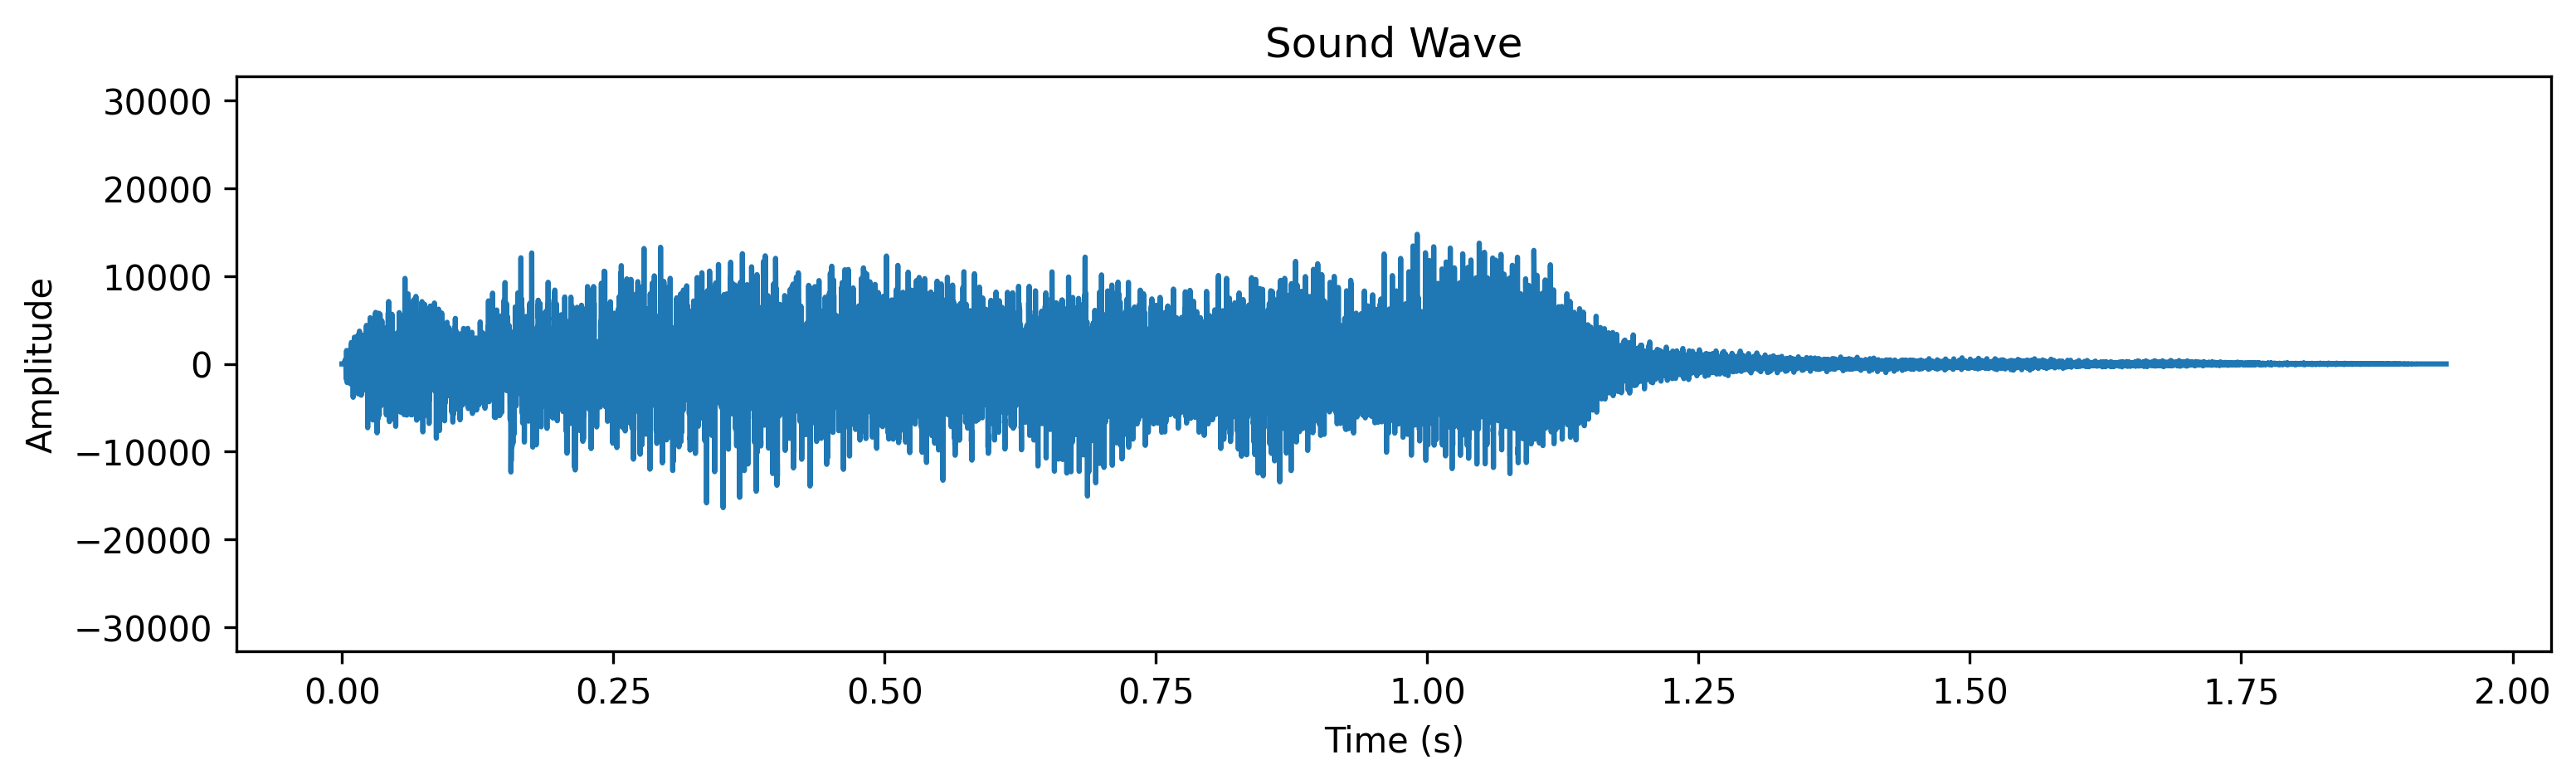

In [22]:
rate, samples = wavfile.read("tada.wav")
sw = SoundWave(rate, samples)
try:
    sw.plot()
except NotImplementedError:
    pass

plt.show()

## Problem 2

- Implement `SoundWave.export()`.
- Use the `export()` method to create two new files containing the same sound as `tada.wav`: one without scaling, and one with scaling (use `force=True`).
- Use `IPython.display.Audio()` to embed the original and two new versions of `tada.wav` in the cells below.

In [23]:
# (a) No scaling
sw.export("tada_noscale.wav")

# (b) With scaling – force=True
sw.export("tada_scaled.wav", force=True)


Exported without scaling: tada_noscale.wav
Exported with scaling: tada_scaled.wav


In [24]:
display(Audio("tada.wav", autoplay=False, element_id='orig'))
display(Audio("tada_noscale.wav", autoplay=False, element_id='noscale'))
display(Audio("tada_scaled.wav", autoplay=False, element_id='scaled'))


## Problem 3

- Implement `generate_note()`.
- Use `generate_note()` to create an A tone that lasts for two seconds. Embed it in the cell below.

In [25]:
def generate_note(frequency, duration):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 Hz.
    
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    sample_rate = 44100  # Standard sample rate for audio
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    samples = np.sin(2.0 * np.pi * frequency * t).astype(np.float32)
    return SoundWave(sample_rate, samples)

In [26]:
a_tone = generate_note(440.00, 2)
b_tone = generate_note(493.88, 2)
c_tone = generate_note(523.25, 2)
d_tone = generate_note(587.33, 2)
e_tone = generate_note(659.25, 2)
f_tone = generate_note(698.46, 2)
g_tone = generate_note(783.99, 2)
a_prime_tone = generate_note(880.00, 2)

## Problem 4

- Implement `SoundWave.__add__()`.
- Generate a three-second A minor chord (A, C, and E) and embed it in the first cell below.
- Implement `SoundWave.__rshift__()`.
- Generate the arpeggio A &rarr; C &rarr; E, where each tone lasts one second, and embed it in the second cell below.

In [27]:
# Fundamental frequencies
a = generate_note(440.00, 3)  # A   (440.00 Hz)
c = generate_note(523.25, 3)  # C   (523.25 Hz)
e = generate_note(659.25, 3)  # E   (659.25 Hz)


chord = a + c + e
chord.export("am_chord.wav", force=True)
display(Audio("am_chord.wav", autoplay=False, element_id="am-chord"))


Exported with scaling: am_chord.wav


In [28]:
a1 = generate_note(440, 1)
c1 = generate_note(261.63, 1)
e1 = generate_note(329.63, 1)

arpeggio = a1 >> c1 >> e1
arpeggio.export("am_arpeggio.wav", force=True)
display(Audio("am_arpeggio.wav", autoplay=False, element_id="am-arpeggio"))


Exported with scaling: am_arpeggio.wav


## Problem 5

- Implement `simple_dft()` with the formula $c=F_nf$, where $F_n$ is the n-dimensional DFT matrix.
- In the cell below, use `np.allclose()` to check that `simple_dft()` and `scipy.fftpack.fft()` give the same result (after scaling).

In [29]:
def simple_dft(samples):
    """Compute the DFT of an array of samples.

    Parameters:
        samples ((n,) ndarray): an array of samples.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """
    n = len(samples)
    j, k = np.meshgrid(np.arange(n), np.arange(n))  # shape (n, n)
    W = np.exp(-2j * np.pi * j * k / n)             # DFT matrix F_n
    return W @ samples


In [30]:
samples = np.random.rand(64)
assert np.allclose(simple_dft(samples), fft(samples)) 
# Should return True if `simple_dft()` and `scipy.fftpack.fft()` give the same result (after scaling).

## Problem 6

- Implement `simple_fft()`.
- In the cell below:
    - Generate an array of $8192$ random samples and take its DFT using `simple_dft()`, `simple_fft()`, and `scipy.fftpack.fft()`.
    - Print the runtimes of each computation.
    - Use `np.allclose()` to check that `simple_fft()` and `scipy.fftpack.fft()` give the same result (after scaling).

In [31]:
def simple_fft(samples, threshold=1):
    """Compute the DFT using the FFT algorithm.
    
    Parameters:
        samples ((n,) ndarray): an array of samples.
        threshold (int): when a subarray of samples has fewer
            elements than this integer, use simple_dft() to
            compute the DFT of that subarray.
    
    Returns:
        ((n,) ndarray): The DFT of the given array.
    """
    n = len(samples)
    if n <= threshold:
        return simple_dft(samples)

    if (n & (n - 1)) != 0:
        raise ValueError("Input size must be a power of 2")

    even = simple_fft(samples[::2], threshold)
    odd = simple_fft(samples[1::2], threshold)

    factor = np.exp(-2j * np.pi * np.arange(n) / n)
    return np.concatenate([even + factor[:n // 2] * odd,
                           even - factor[:n // 2] * odd])

In [32]:
import time

# Generate random signal of length 8192
samples = np.random.rand(8192)

# Time simple_dft
start = time.time()
dft_result = simple_dft(samples)
dft_time = time.time() - start

# Time simple_fft
start = time.time()
fft_result = simple_fft(samples, threshold=32)  # threshold chosen for speed
fft_time = time.time() - start

# Time scipy.fft
start = time.time()
scipy_result = fft(samples)
scipy_time = time.time() - start

# Output runtimes
print(f"simple_dft: {dft_time:.4f} s")
print(f"simple_fft: {fft_time:.4f} s")
print(f"scipy.fft: {scipy_time:.4f} s")

# Check correctness
print("simple_fft ≈ scipy.fft:", np.allclose(fft_result, scipy_result))


simple_dft: 5.8829 s
simple_fft: 0.0147 s
scipy.fft: 0.0001 s
simple_fft ≈ scipy.fft: True


## Problem 7

- Modify `SoundWave.plot()` so that it accepts a boolean. When the boolean is `True`, take the DFT of the stored samples and plot (in a new subplot) the frequencies present on the $x$-axis and the magnituds of those frequences on the $y$-axis. Only the display the first half of the plot, and adjust the $x$-axis so that it correctly shows the frequencies in Hertz.
- Display the plot of the DFT of the A tone from Problem 4 the first cell below.
- Display the plot of the DFT of the A minor chord from Problem 4 in the second cell below.

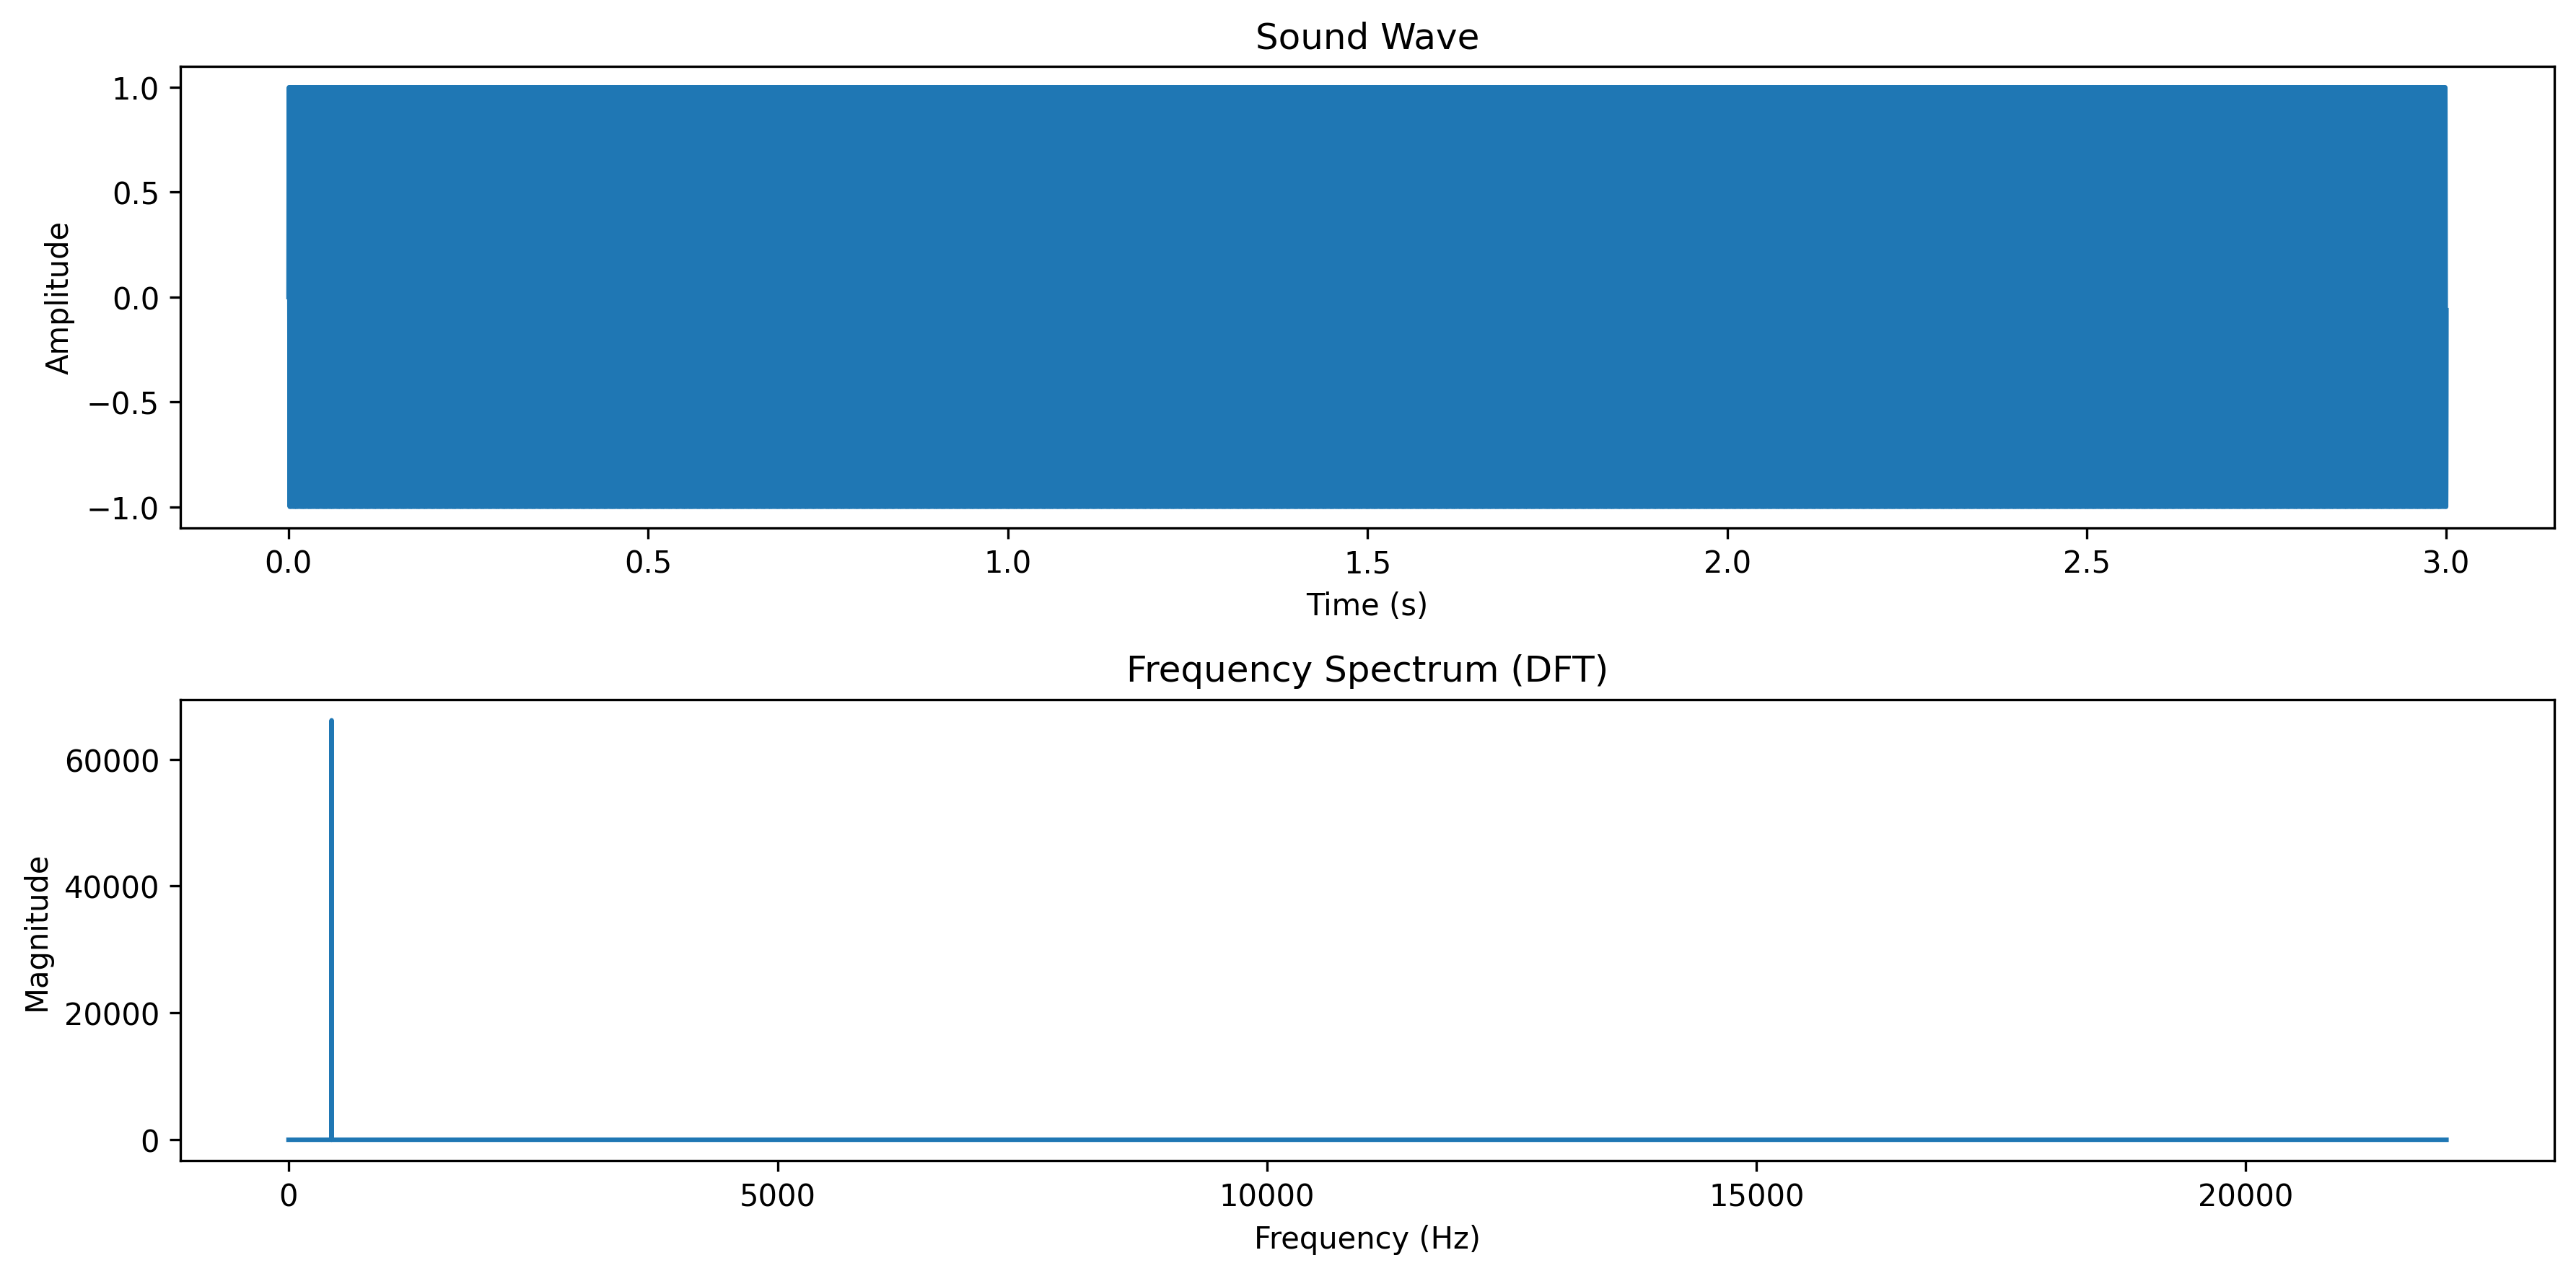

In [33]:
a.plot(show_dft=True)
plt.show()


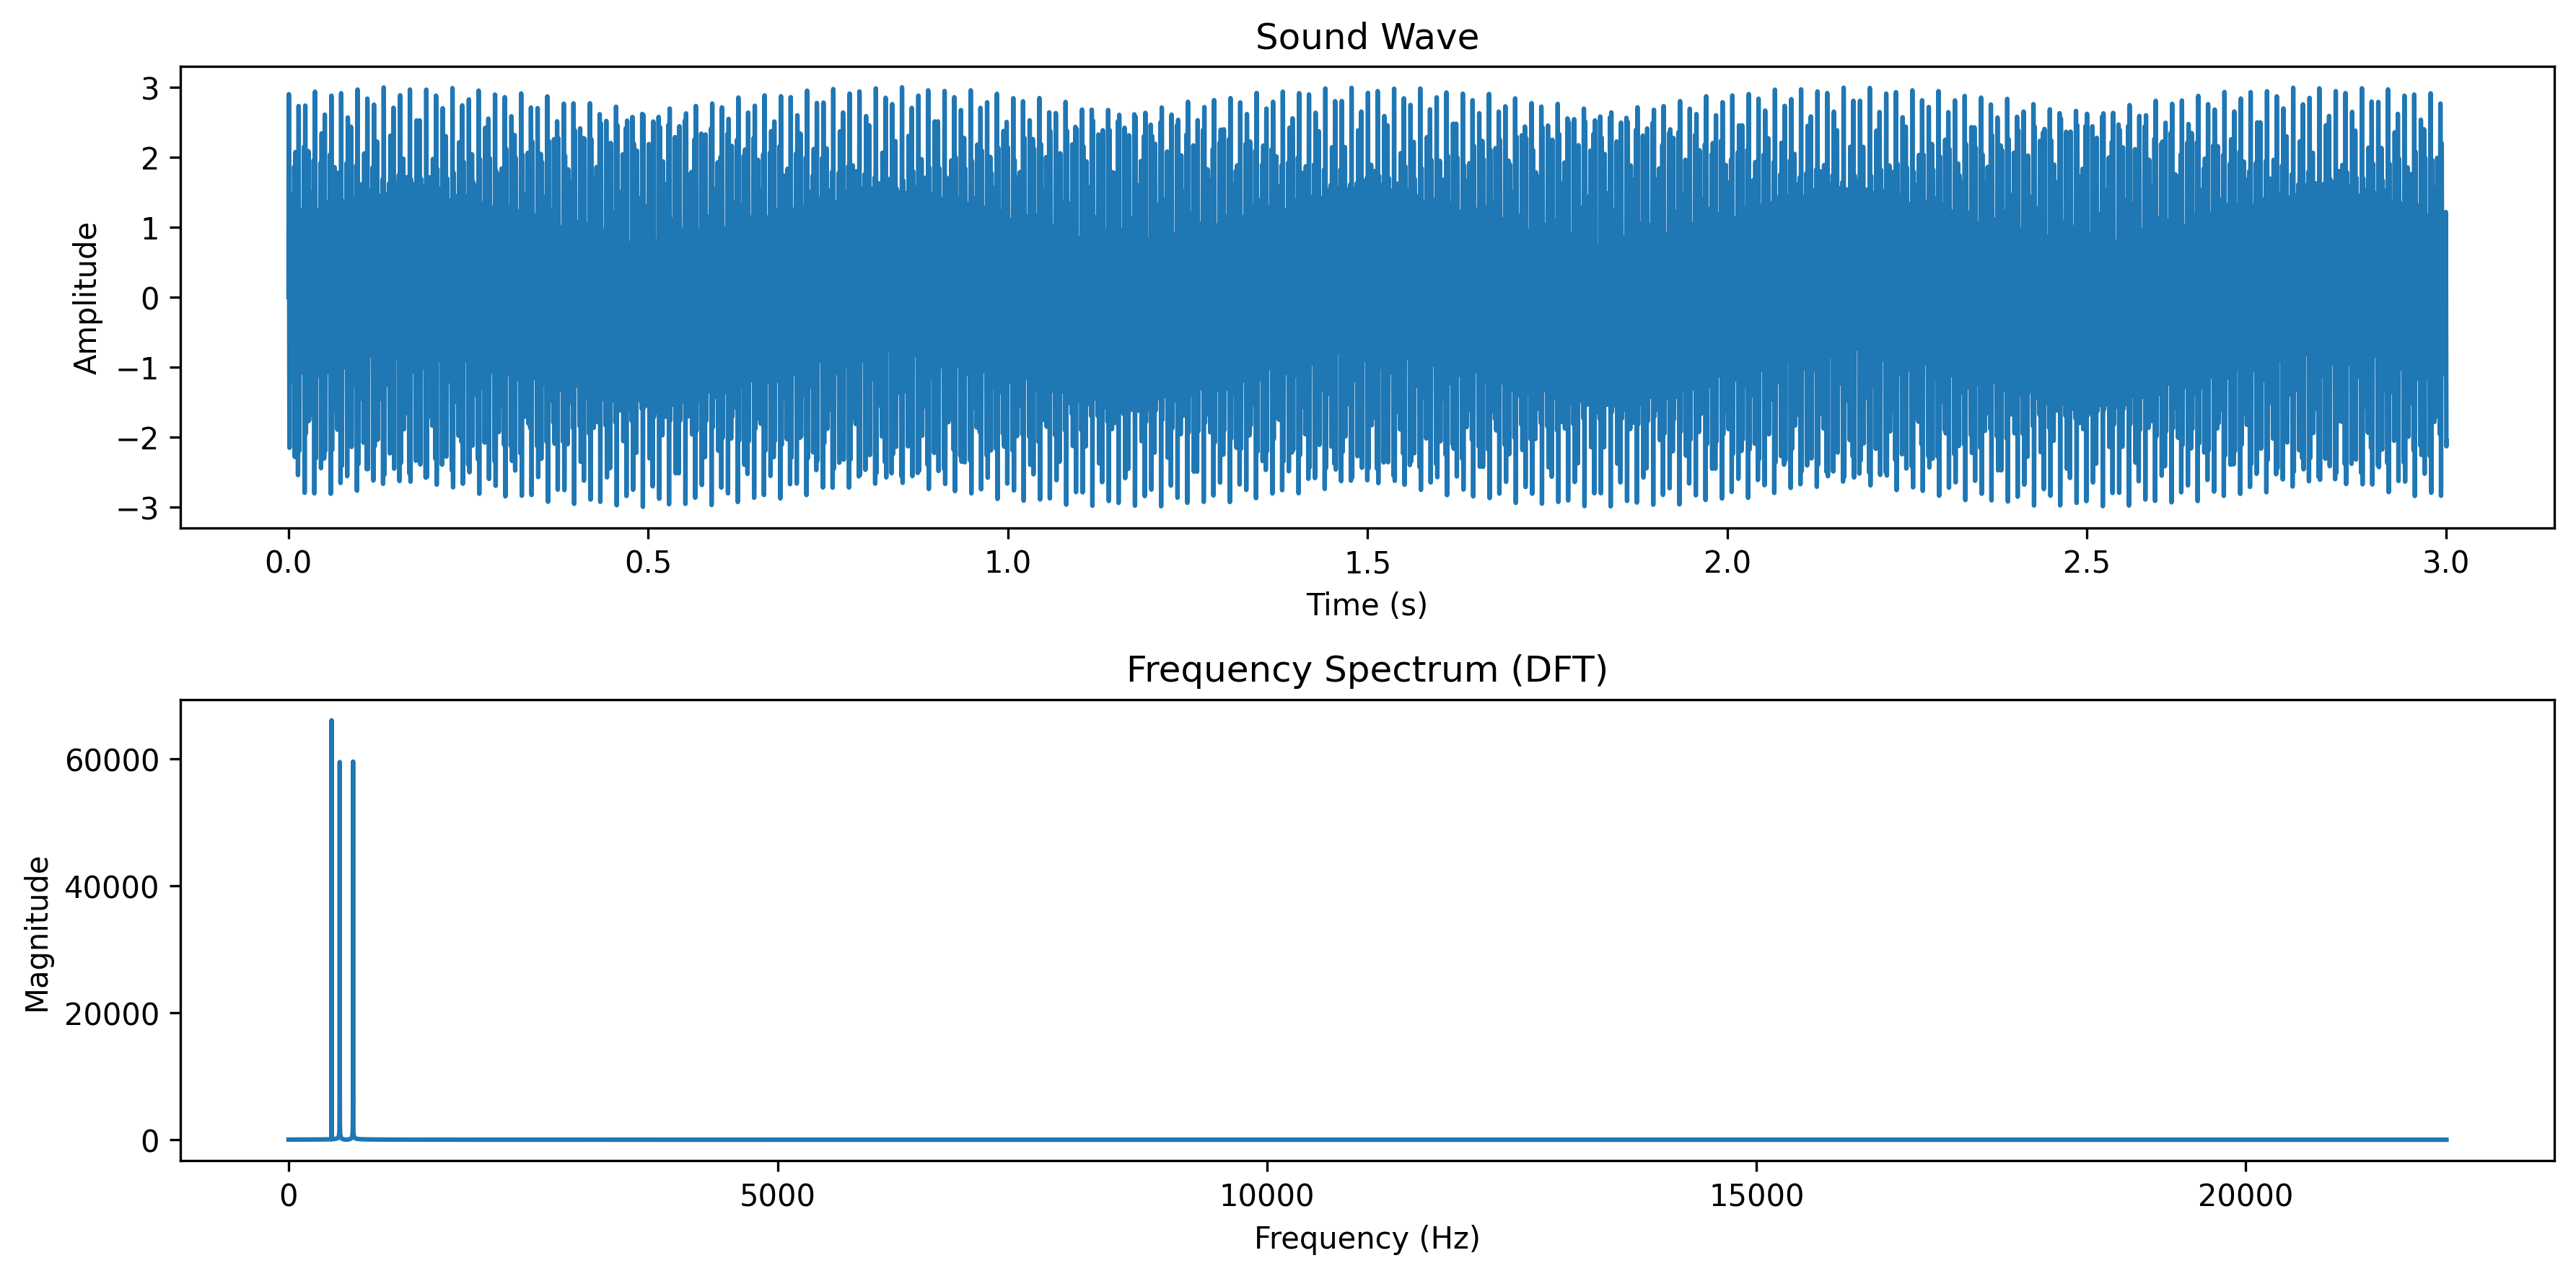

In [34]:
chord.plot(show_dft=True)
plt.show()


## Problem 8

Use the DFT to determine the individual notes that are present in `mystery_chord.wav`.

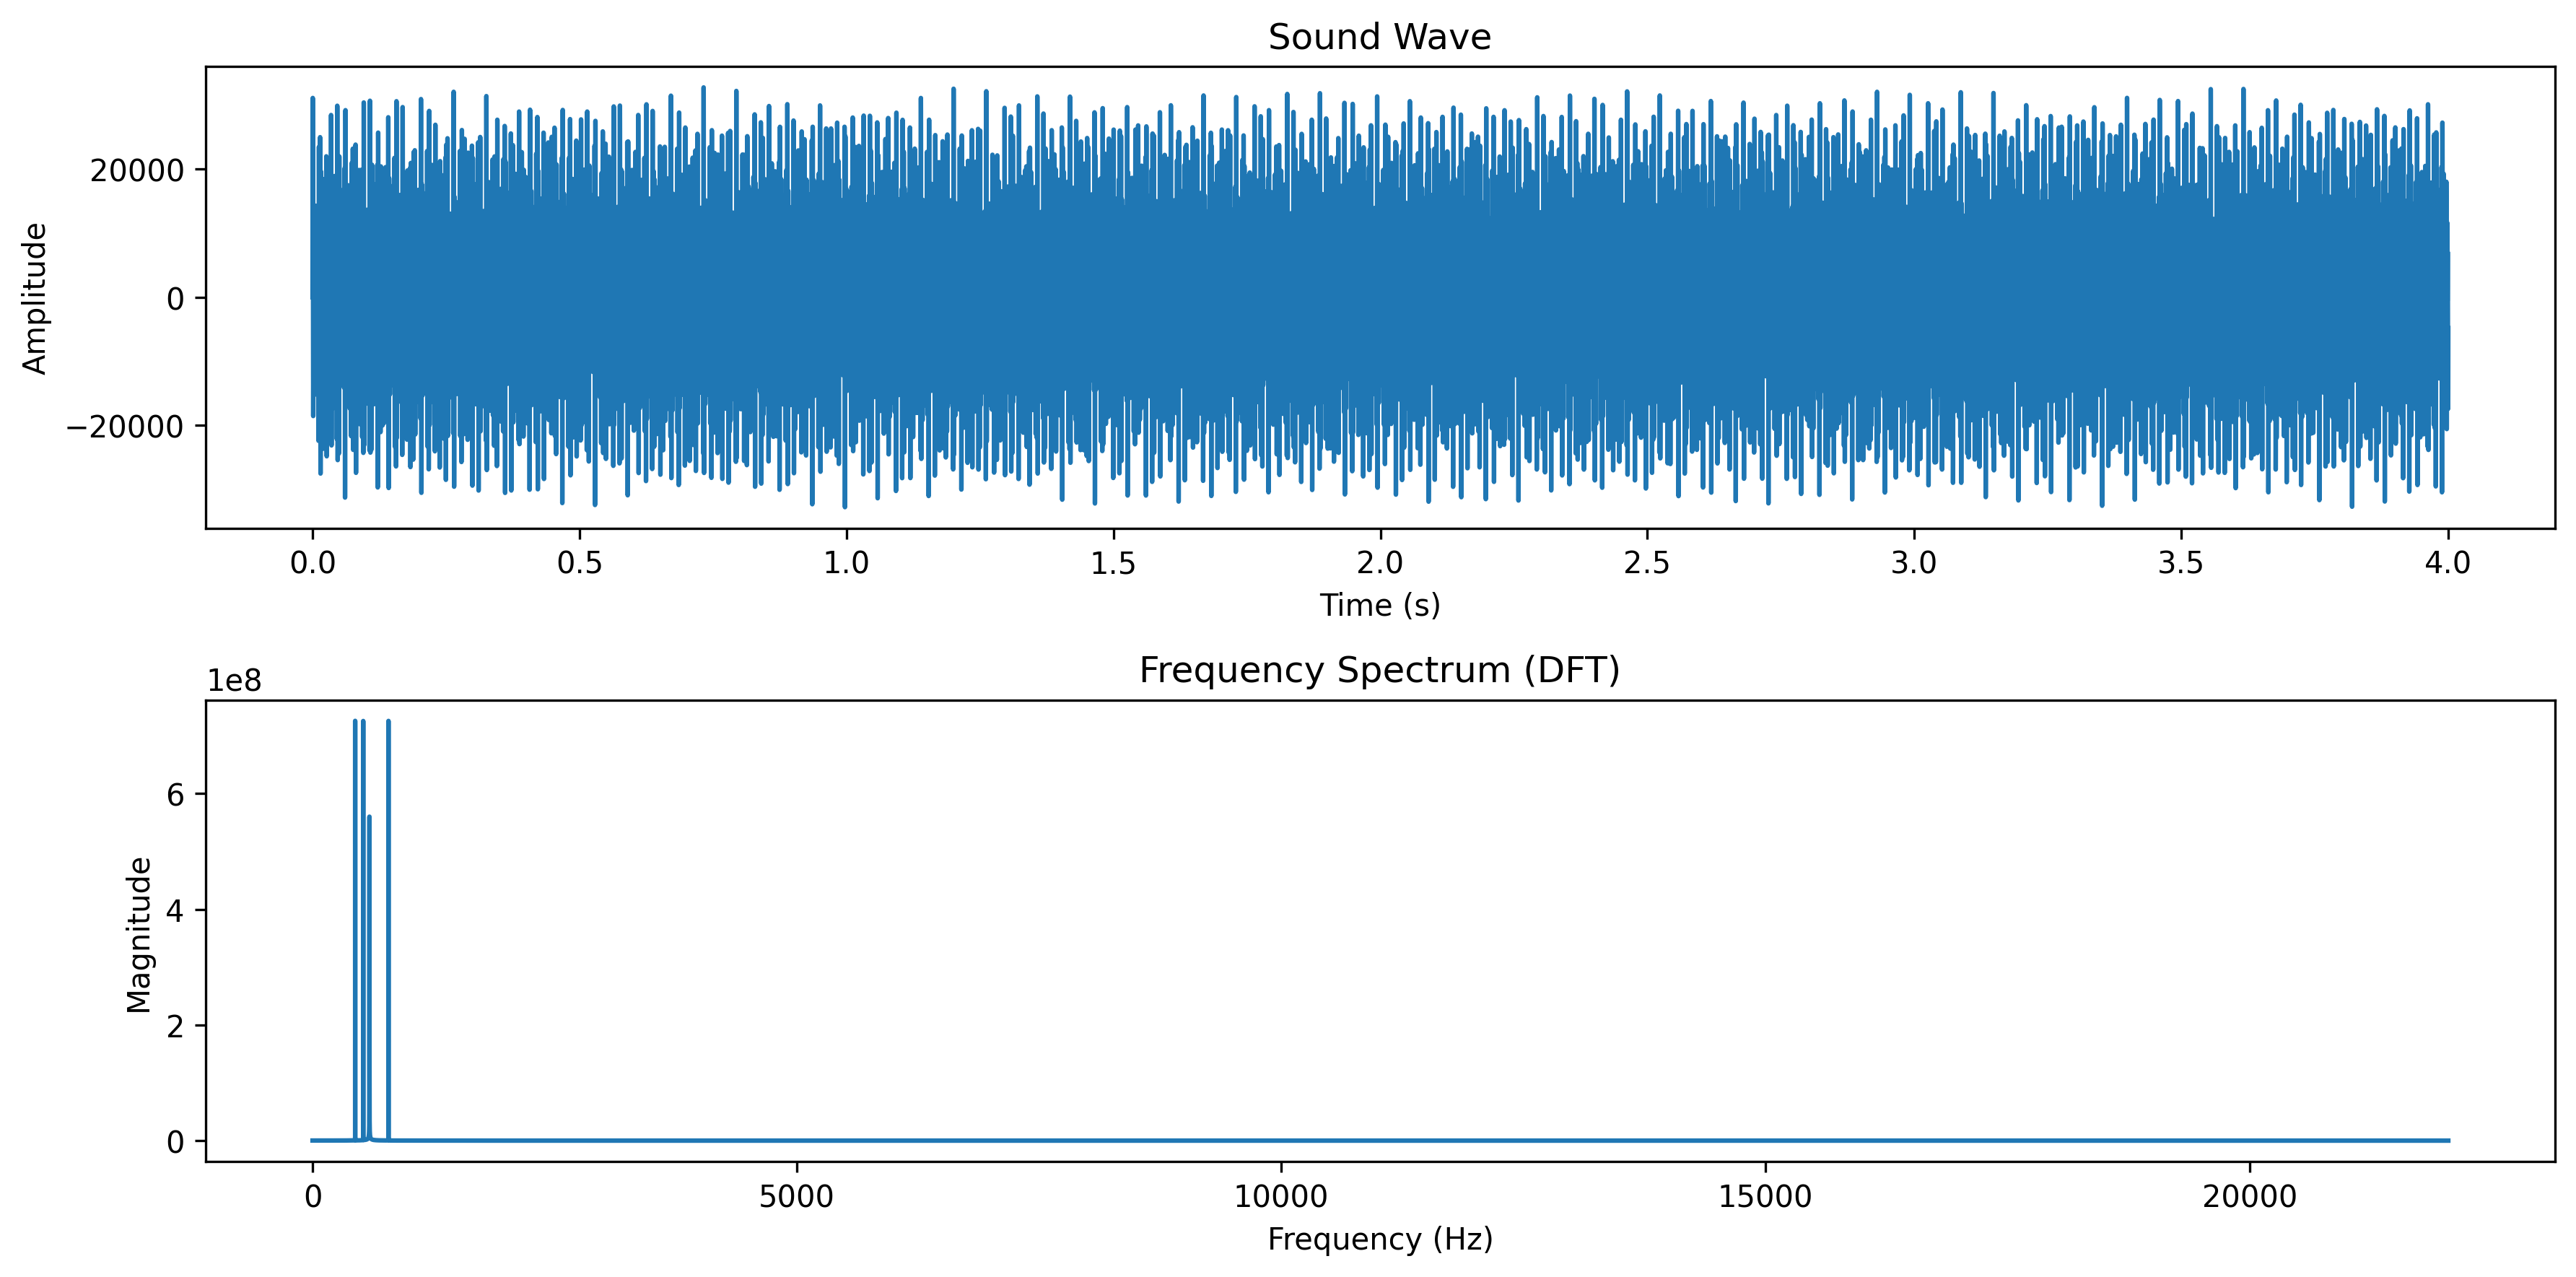

Detected notes and frequencies:
A: 440.00 Hz
C: 523.20 Hz
D: 586.80 Hz
D: 587.00 Hz
D: 587.20 Hz


In [ ]:
note_freqs = {
  "A4": 440.00,
  "B4": 493.88,
  "C5": 523.25,
  "D5": 587.33,
  "E5": 659.25,
  "F5": 698.46,
  "G5": 783.99,
  "A5": 880.00
}

rate, samples = wavfile.read("mystery_chord.wav")
mystery_chord = SoundWave(rate, samples)

mystery_chord.plot(show_dft=True)
plt.show()

n = len(mystery_chord.samples)

freqs = mystery_chord.freq
magnitudes = np.abs(np.fft.rfft(mystery_chord.samples))
magnitudes[0] = 0  # Ignore DC component
freqs = np.fft.rfftfreq(n, d=1/rate)
top_indices = np.argsort(magnitudes)[-10:][::-1]
top_freqs = freqs[top_indices]
top_freqs = np.unique(np.round(top_freqs, 1))[:5]  # Round and deduplicate

detected_notes = []
for f in top_freqs:
    closest_note = min(note_freqs, key=lambda note: abs(note_freqs[note] - f))
    detected_notes.append((closest_note, f))
print("Detected notes and frequencies:")
for note, freq in detected_notes:
    print(f"{note}: {freq:.2f} Hz")

top_indices = np.argsort(magnitudes)[-10:][::-1]
top_freqs = freqs[top_indices]

In [36]:
def find_fundamental_peaks(samples, rate, num_peaks=3, tol_hz=2.0):
    """
    Return the `num_peaks` strongest, well‑separated frequencies (in Hz)
    from the real‑DFT of `samples` at sample rate `rate`.
    tol_hz controls how close two peaks may be before they're considered the same.
    """
    # 1) Compute real FFT magnitudes and corresponding freqs
    mags = np.abs(np.fft.rfft(samples))
    freqs = np.fft.rfftfreq(len(samples), d=1/rate)
    mags[0] = 0        # ignore DC

    # 2) Sort bins by descending magnitude
    sorted_idx = np.argsort(mags)[::-1]

    # 3) Collect peaks with at least tol_hz separation
    peaks = []
    for idx in sorted_idx:
        f = freqs[idx]
        if all(abs(f - p) > tol_hz for p in peaks):
            peaks.append(f)
        if len(peaks) >= num_peaks:
            break

    return peaks


In [41]:
rate, samples = wavfile.read("mystery_chord.wav")
# Suppose we know it’s a triad → num_peaks=3
peaks = find_fundamental_peaks(samples, rate, num_peaks=5, tol_hz=2.0)
print("Raw detected peaks (Hz):", np.round(peaks, 2))

# Map to nearest note names
note_freqs = {
    "A4": 440.00, "B4": 493.88, "C5": 523.25,
    "D5": 587.33, "E5": 659.25, "F5": 698.46,
    "G5": 783.99, "A5": 880.00
}
detected = []
for f in peaks:
    name = min(note_freqs, key=lambda n: abs(note_freqs[n] - f))
    detected.append(name)
print("Detected notes:", detected)


Raw detected peaks (Hz): [440.   784.   523.25 587.5  585.25]
Detected notes: ['A4', 'G5', 'C5', 'D5', 'D5']


I am wondering that what should I do if I find multiple peaks.